In [1]:
import numpy
import time
import matplotlib.pyplot as plt
import os
import sys 
import nest
import nest.raster_plot
print(nest.version())

nest.ResetKernel()
startbuild = time.time()

NEST nest-2.18.0


In [2]:
#  BEST RESULT

# dt = 0.02    # the resolution in ms
# delay = 1.0    # synaptic delay in ms
# epsilon = 0.4  # connection probability
# J = 0.07   # postsynaptic amplitude in mV
# tau_syn = [5., 2., 100., 5.]  # [ms]
# V_reset = -55.0  # mV 


#### Definition of normalization functions
These functions compute the post-synaptic potential (PSP) based on the neurons' membrane parameters and synaptic decay

In [3]:
def LambertWm1(x):
    return nest.ll_api.sli_func('LambertWm1', float(x))

def ComputePSPNorm(tau_mem, C_mem, tau_syn):
    a = (tau_mem / tau_syn)
    b = (1.0 / tau_syn -1.0 / tau_mem)
    t_max = 1.0 / b * (-LambertWm1(-numpy.exp(-1.0/a)/a) - 1.0 / a)
    return (numpy.exp(1.0) / (tau_syn * (C_mem * b) * 
            ((numpy.exp( -t_max / tau_mem) - numpy.exp(-t_max / tau_syn)) / b - 
            t_max * numpy.exp(-t_max / tau_syn))))

#### Assigning the simulation parameters to variables.

In [4]:
dt = 0.1   # the resolution in ms
simtime = 3000.0  # Simulation time in ms
delay = 0.5   # synaptic delay in ms

In [5]:
eta = 2.0  # external rate relative to threshold rate
# epsilon = 0.4 # connection probability


# HERE DIFFERENT CONNECTION PROBABILITIES CAN BE DEFINED FOR THE DIFFERENT TYPES OF CONNECTIONS
epsilon_same = 0.35 # connection probability between neurons of a same population
epsilon_opposite = 0.20 # connection probability between neurons of a different population
epsilon_inh_to_pop = 0.35 # connection probability between inhibitory interneurons and the 2 populations and viceversa
epsilon_inh_same = 0.25 # connection probability of recurrent connections for inhibitory interneurons
epsilon_input = 1.0 # connection probability of the external input (input to all neurons in this case)

Network numerosities 

In [6]:
order = 200
NA = 2 * order  # number of excitatory neurons in pop A
NB = 2 * order  # number of excitatory neurons in pop B
NI = 1 * order  # number of inhibitory neurons
N_neurons = NA + NB + NI   # number of neurons in total
N_rec = order * (2+2+1)  # record from all neurons

#### Definition of connectivity parameters

In [7]:
CE = int(epsilon_same * (NA) + epsilon_opposite * (NA))  # number of excitatory synapses per neuron #TODO: synapses per neuron should be NMDA+AMPA
CI = int(epsilon_inh_to_pop * NI)  # number of inhibitory synapses per neuron
C_tot = int(CI + CE)      # total number of synapses per neuron

print("tot synapses per neuron: %d" % C_tot)

tot synapses per neuron: 290


#### Initialization of the parameters of the integrate and fire neurons and synapses. 


In [8]:
tauMem = 20.0  # time constant of membrane potential in ms
theta = -55.0  # membrane threshold potential in mV
J = 0.04 # postsynaptic amplitude in mV
nr_ports = 4  # number of receptor types (noise-related, AMPA, NMDA, GABA)
  
tau_syn = [5., 2., 100., 5.]  # [ms]

V_membrane = -70.0  # mV 
V_threshold = -50.0  # mV
V_reset = -55.0  # mV 

Storing the excitatory and inhibitory neurons' parameters in corresponding dictionaries
#### Excitatory

In [9]:
exc_neuron_params = {
    "E_L": V_membrane,
    "V_th": V_threshold,
    "V_reset": V_reset,
    "C_m": 500.0,  # pF (0.5nF)
    "tau_m": 20.0,
    "t_ref": 2.0, 
    "tau_syn": tau_syn
}

#### Inhibitory

In [10]:
inh_neuron_params = {
    "E_L": V_membrane,
    "V_th": V_threshold,
    "V_reset": V_reset,
    "C_m": 200.0,  # pF (0.2nF)  
    "tau_m": 10.0,
    "t_ref": 1.0,
    "tau_syn": tau_syn 
} 

The synaptic currents are normalized such that the amplitude of the PSP is J and each connection weight is calibrated on the specific neurotransmitter time constant (from Brunel 2001)

In [11]:
J = 0.04  # mV -> this means that it takes 200 simultaneous events to drive the spiking activity 

J_unit_noise = ComputePSPNorm(20.0, 500.0, 5.0)
J_norm_noise = J / J_unit_noise 

J_unit_AMPA = ComputePSPNorm(20.0, 500.0, 2.0)
J_norm_AMPA = J / J_unit_AMPA 


J_unit_NMDA = ComputePSPNorm(20.0, 500.0, 100.0)
J_norm_NMDA = J / J_unit_NMDA 
J_norm_NMDA = 0.05  # the weight for the NMDA is set at 0.05, otherwise it would be 0

J_unit_GABA = ComputePSPNorm(10.0, 200.0, 5.0)
J_norm_GABA = J / J_unit_GABA




print("J_unit_NMDA: %f" % J_unit_NMDA)
print("noise: %f" % J_norm_noise)
print("AMPA: %f" % J_norm_AMPA)
print("NMDA: %f" % J_norm_NMDA)  
print("GABA: %f" % J_norm_GABA)

J_unit_NMDA: -inf
noise: 11.438166
AMPA: 8.624186
NMDA: 0.050000
GABA: 1.498242


/home/amtra/.local/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning:divide by zero encountered in double_scalars


Definition of threshold rate, which is the external rate needed to fix the membrane potential around its threshold, the external firing rate and the rate of the poisson generator which is multiplied by the in-degree CE and converted to Hz by multiplication by 1000.

In [12]:
nu_th_noise = (numpy.abs(V_threshold) * 500.0) / (J_norm_noise * CE * numpy.exp(1) * 20.0 * 10.0)
nu_ex = eta * nu_th_noise
p_rate = 1000.0 * nu_ex * CE


p_rate_inh = p_rate / 1.3   # the rate for the noise entering in the inhibitory population is reduced 


print("p_rate: %f" % p_rate)
print("p_rate_inh: %f" % p_rate_inh)

p_rate: 8040.612409
p_rate_inh: 6185.086469


In [13]:
nest.SetKernelStatus({"resolution": dt, "print_time": True,
                      "overwrite_files": True})

### Building the network
Creation of the nodes using Create. We store the returned handles in variables for later reference. Here the excitatory and inhibitory, as well as the poisson generator and three spike recorders. The spike recorders will later be used to record excitatory and inhibitory spikes. Properties of the nodes are specified via SetDefaults, which expects a dictionary.

In [14]:
k = 1.0 

p_rate_input=  p_rate / 24.0   #rate for the input Poisson generator to popA (scaled with respect to the noise)
p_rate_input_A = (p_rate_input) * k 
p_rate_input_B = (p_rate_input) * (1-k)

print("p_rate: %f" % p_rate_input)

nest.SetDefaults("iaf_psc_exp_multisynapse", exc_neuron_params)
pop_A = nest.Create("iaf_psc_exp_multisynapse", NA)
pop_B = nest.Create("iaf_psc_exp_multisynapse", NB)

nest.SetDefaults("iaf_psc_exp_multisynapse", inh_neuron_params)
pop_inh = nest.Create("iaf_psc_exp_multisynapse", NI)

nest.SetDefaults("poisson_generator", {"rate": p_rate})    #poisson generator for the noise in input to popA and popB
PG_noise = nest.Create("poisson_generator")

nest.SetDefaults("poisson_generator", {"rate": p_rate_inh})   #poisson generator for the noise in input to popinh
PG_noise_to_inh = nest.Create("poisson_generator")

# INPUT GENERATOR
nest.SetDefaults("poisson_generator", {"rate": p_rate_input_A, "origin": 0.0, "start":200.0, "stop":1000.0} )   #poisson generator for the input to popA
PG_input_NMDA_A = nest.Create("poisson_generator")
nest.SetDefaults("poisson_generator", {"rate": p_rate_input_A, "origin": 0.0, "start":200.0, "stop":1000.0} )   #poisson generator for the input to popA
PG_input_AMPA_A = nest.Create("poisson_generator")
nest.SetDefaults("poisson_generator", {"rate": p_rate_input_B, "origin": 0.0, "start":200.0, "stop":1000.0} )   #poisson generator for the input to popB
PG_input_NMDA_B = nest.Create("poisson_generator")
nest.SetDefaults("poisson_generator", {"rate": p_rate_input_B, "origin": 0.0, "start":200.0, "stop":1000.0} )   #poisson generator for the input to popB
PG_input_AMPA_B = nest.Create("poisson_generator")


spikes_a = nest.Create("spike_detector")
spikes_b = nest.Create("spike_detector")
spikes_i = nest.Create("spike_detector")

p_rate: 335.025517


#### Assign NEST-related details to populations

In [15]:
nest.SetStatus(spikes_a, [{"label": "Exc. pop. A",
                          "withtime": True,
                          "withgid": True,
                          "to_file": True}])

nest.SetStatus(spikes_b, [{"label": "Exc. pop. B",
                          "withtime": True,
                          "withgid": True,
                          "to_file": True}])

nest.SetStatus(spikes_i, [{"label": "Inh. pop.",
                          "withtime": True,
                          "withgid": True,
                          "to_file": True}])

### Synapse model definition
Definition of a synapse using CopyModel, which expects the model name of a pre-defined synapse, the name of the customary synapse and an optional parameter dictionary. The parameters defined in the dictionary will be the default parameter for the customary synapse. Here we define one synapse for the excitatory and one for the inhibitory connections giving the previously defined weights and equal delays.

In [16]:
w_plus = 1.7     # a synapse tends to be stronger if 2 cells are selective in the same way
w_minus = 0.80    # a synapse tends to be weaker between cells selective for different inputs

# Definition of default synapses

nest.CopyModel("static_synapse", "excitatory_AMPA",
               {"weight": J_norm_AMPA*w_plus, "delay": delay})   # weight for the AMPA synapse from excitatory populations to the inhibitory population is increased
nest.CopyModel("static_synapse", "excitatory_NMDA",
               {"weight": J_norm_NMDA*w_plus, "delay": delay})   # weight for the NMDA synapse from excitatory populations to the inhibitory population is increased
nest.CopyModel("static_synapse", "noise_syn",
               {"weight": J_norm_noise, "delay": delay})
nest.CopyModel("static_synapse", "inhibitory",
               {"weight": -J_norm_GABA, "delay": delay})

# Definition of new types of synapses considering a hebbian rule for the weights (recurrent connections)

nest.CopyModel("static_synapse", "excitatory_AMPA_same",
              {"weight": J_norm_AMPA, "delay": delay})    
nest.CopyModel("static_synapse", "excitatory_NMDA_same",
               {"weight": J_norm_NMDA*w_plus*2.5, "delay": delay})   #  the weight for the recurrent NMDA connections is increased (ramping activity is mainly due to NMDA)


# Definition of new types of synapses considering a hebbian rule for the weights (connections between different populations)

nest.CopyModel("static_synapse", "excitatory_AMPA_opposite",
              {"weight": J_norm_AMPA*w_minus, "delay": delay})  # the weight for the AMPA connections to the opposite population is reduced 
nest.CopyModel("static_synapse", "excitatory_NMDA_opposite",
               {"weight": J_norm_NMDA*w_minus, "delay": delay})   # the weight for the NMDA connections to the opposite population is reduced  

# Definition of new types of synapses for the input (to popA only) by considering weights of the exc neurotransmitters or the same weight used for the noise

nest.CopyModel("static_synapse", "excitatory_NMDA_input",
               {"weight": J_norm_NMDA*w_plus, "delay": delay})  # the weight for the input NMDA synapse is increased
nest.CopyModel("static_synapse", "excitatory_AMPA_input",
               {"weight": J_norm_AMPA, "delay": delay}) 



# Definition of new types of synapses for the popinh to popA and popB connections (maybe a higher delay cam be useful to see a decreasing activity of the non stimulated pop)
nest.CopyModel("static_synapse", "inhibitory_opposite",
               {"weight": -J_norm_GABA*w_plus, "delay": delay})  # the weight for the inhibitory connections to popA and popB is increased


Assign the corresponding receptor type to each of the synapses models defined above 

In [17]:
#DEFAULT NAMES FOR THE SYNAPSES

noise_syn = {"model": "noise_syn",
                 "receptor_type": 1}
AMPA_syn = {"model": "excitatory_AMPA",
                 "receptor_type": 2}
NMDA_syn = {"model": "excitatory_NMDA",
                 "receptor_type": 3}
GABA_syn = {"model": "inhibitory",
                 "receptor_type": 4}


# NAMES FOR THE NEW SYNAPSES (WITH MODIFIED WEIGHTS OR DELAYS) --> USE THESE NAMES IN THE FOLLOWING CELLS

AMPA_syn_same = {"model": "excitatory_AMPA_same",
                     "receptor_type": 2}
NMDA_syn_same = {"model": "excitatory_NMDA_same",
                     "receptor_type": 3}


AMPA_syn_opposite = {"model": "excitatory_AMPA_opposite",
                     "receptor_type": 2}
NMDA_syn_opposite = {"model": "excitatory_NMDA_opposite",
                     "receptor_type": 3}



NMDA_syn_input = {"model": "excitatory_NMDA_input",
                     "receptor_type": 3}
AMPA_syn_input = {"model": "excitatory_AMPA_input",
                     "receptor_type": 2}



GABA_syn_opposite = {"model": "inhibitory_opposite",
                 "receptor_type": 4}



### Connecting Devices
Connecting the previously defined poisson generator to the excitatory and inhibitory neurons using the excitatory synapse. Since the poisson generator is connected to all neurons in the population the default rule (all_to_all) of Connect is used. The synaptic properties are inserted via syn_spec which expects a dictionary when defining multiple variables or a string when simply using a pre-defined synapse.

In [18]:
#EXTERNAL NOISE AND INPUT --> when using a certain type of generator, only one type of syn_spec can be used

nest.Connect(PG_noise, pop_A, syn_spec=noise_syn)
nest.Connect(PG_noise, pop_B, syn_spec=noise_syn)
nest.Connect(PG_noise_to_inh, pop_inh, syn_spec=noise_syn)
#nest.Connect(PG_input, pop_A, syn_spec=noise_syn)
#nest.Connect(PG_input, pop_A, syn_spec=AMPA_syn_input)
#nest.Connect(PG_input, pop_A, syn_spec=NMDA_syn_input)


#Recording devices
nest.Connect(pop_A, spikes_a)
nest.Connect(pop_B, spikes_b)
nest.Connect(pop_inh, spikes_i)

### Connecting Network
Connecting the <b>excitatory population</b>  to all neurons using the pre-defined excitatory synapse. Beforehand, the connection parameter are defined in a dictionary. Here we use the connection rule pairwise_bernoulli, which requires the connection probabilities of having a synapse between two population. Since the synapse specification is reduced to assigning the pre-defined excitatory synapse it suffices to insert a string.

In [19]:
# These lines allow to have different connection probabilities for different types of connections

conn_params_ex_same = {'rule': 'pairwise_bernoulli', 'p': epsilon_same}
conn_params_ex_opposite = {'rule': 'pairwise_bernoulli', 'p': epsilon_opposite}
conn_params_ex_inh_to_pop = {'rule': 'pairwise_bernoulli', 'p': epsilon_inh_to_pop}
conn_params_ex_inh_same = {'rule': 'pairwise_bernoulli', 'p': epsilon_inh_same}

#### Population A

In [20]:
# Recurrent
#conn_params_ex = {'rule': 'pairwise_bernoulli', 'p': epsilon}
#nest.Connect(pop_A, pop_A, conn_params_ex, AMPA_syn)
#nest.Connect(pop_A, pop_A, conn_params_ex, NMDA_syn)


# To pop B
#nest.Connect(pop_A, pop_B, conn_params_ex, AMPA_syn)
#nest.Connect(pop_A, pop_B, conn_params_ex, NMDA_syn)


# To pop inh.
#nest.Connect(pop_A, pop_inh, conn_params_ex, AMPA_syn)
#nest.Connect(pop_A, pop_inh, conn_params_ex, NMDA_syn)


# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

# CHANGE THE NAME OF THE LAST PARAMETER ACCORDING TO THE TYPE OF SYNAPSES THAT NEEDS TO BE TESTED

conn_par_ext = {'rule': 'pairwise_bernoulli', 'p': epsilon_input}
nest.Connect(PG_input_NMDA_A, pop_A, conn_par_ext, NMDA_syn_input)

conn_par_ext = {'rule': 'pairwise_bernoulli', 'p': epsilon_input}
nest.Connect(PG_input_AMPA_A, pop_A, conn_par_ext, AMPA_syn_input)

conn_par_ext = {'rule': 'pairwise_bernoulli', 'p': epsilon_input}
nest.Connect(PG_input_NMDA_B, pop_B, conn_par_ext, NMDA_syn_input)

conn_par_ext = {'rule': 'pairwise_bernoulli', 'p': epsilon_input}
nest.Connect(PG_input_AMPA_B, pop_B, conn_par_ext, AMPA_syn_input)

# Recurrent
nest.Connect(pop_A, pop_A, conn_params_ex_same, AMPA_syn_same)
nest.Connect(pop_A, pop_A, conn_params_ex_same, NMDA_syn_same)


# To pop B
nest.Connect(pop_A, pop_B, conn_params_ex_opposite, AMPA_syn_opposite)
nest.Connect(pop_A, pop_B, conn_params_ex_opposite, NMDA_syn_opposite)


# To pop inh.
nest.Connect(pop_A, pop_inh, conn_params_ex_inh_to_pop, AMPA_syn)
nest.Connect(pop_A, pop_inh, conn_params_ex_inh_to_pop, NMDA_syn)

#### Population B

In [21]:
# Recurrent
#conn_params_ex = {'rule': 'pairwise_bernoulli', 'p': epsilon}
#nest.Connect(pop_B, pop_B, conn_params_ex, AMPA_syn)
#nest.Connect(pop_B, pop_B, conn_params_ex, NMDA_syn)


# To pop B
#nest.Connect(pop_B, pop_A, conn_params_ex, AMPA_syn)
#nest.Connect(pop_B, pop_A, conn_params_ex, NMDA_syn)


# To pop inh.
#nest.Connect(pop_B, pop_inh, conn_params_ex, AMPA_syn)
#nest.Connect(pop_B, pop_inh, conn_params_ex, NMDA_syn)


# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

# CHANGE THE NAME OF THE LAST PARAMETER ACCORDING TO THE TYPE OF SYNAPSES THAT NEEDS TO BE TESTED

# Recurrent
nest.Connect(pop_B, pop_B, conn_params_ex_same, AMPA_syn_same)
nest.Connect(pop_B, pop_B, conn_params_ex_same, NMDA_syn_same)


# To pop A
nest.Connect(pop_B, pop_A, conn_params_ex_opposite, AMPA_syn_opposite)
nest.Connect(pop_B, pop_A, conn_params_ex_opposite, NMDA_syn_opposite)


# To pop inh.
nest.Connect(pop_B, pop_inh, conn_params_ex_inh_to_pop, AMPA_syn)
nest.Connect(pop_B, pop_inh, conn_params_ex_inh_to_pop, NMDA_syn)

Connecting the <b>inhibitory population</b> to all neurons using the pre-defined inhibitory synapse. The connection parameter as well as the synapse parameter are defined analogously to the connection from the excitatory population defined above.

#### Inhibitory population

In [22]:
# Recurrent
#conn_params_in = {'rule': 'pairwise_bernoulli', 'p': epsilon}
#nest.Connect(pop_inh, pop_inh, conn_params_in, GABA_syn)


# To pop A
#nest.Connect(pop_inh, pop_A, conn_params_in, GABA_syn)


# To pop B
#nest.Connect(pop_inh, pop_B, conn_params_in, GABA_syn)

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #

# CHANGE THE NAME OF THE LAST PARAMETER ACCORDING TO THE TYPE OF SYNAPSES THAT NEEDS TO BE TESTED

# Recurrent
nest.Connect(pop_inh, pop_inh, conn_params_ex_inh_same, GABA_syn)


# To pop A
nest.Connect(pop_inh, pop_A, conn_params_ex_inh_to_pop, GABA_syn_opposite)


# To pop B
nest.Connect(pop_inh, pop_B, conn_params_ex_inh_to_pop, GABA_syn_opposite)


### Simulation of the network.

In [23]:
endbuild = time.time() # Storage of the time point after the buildup of the network in a variable.
print("Simulating")
nest.Simulate(simtime)
endsimulate = time.time() # Storage of the time point after the simulation of the network in a variable.

Simulating


In [24]:
# Reading out the total number of spikes received from the spike recorder connected to 
# the excitatory population and the inhibitory population.
events_ex_a = nest.GetStatus(spikes_a, "n_events")[0]
events_ex_b = nest.GetStatus(spikes_b, "n_events")[0]
events_in = nest.GetStatus(spikes_i, "n_events")[0]

# Calculation of the average firing rate of the excitatory and the inhibitory neurons 
# by dividing the total number of recorded spikes by the number of neurons recorded from and the simulation time. 
# The multiplication by 1000.0 converts the unit 1/ms to 1/s=Hz.
rate_ex_a = events_ex_a / simtime * 1000.0 / NA
rate_ex_b = events_ex_b / simtime * 1000.0 / NB
rate_in = events_in / simtime * 1000.0 / NI

# Reading out the number of connections established using the excitatory and inhibitory synapse model. 
# The numbers are summed up resulting in the total number of synapses.
num_synapses = (nest.GetDefaults("excitatory_AMPA")["num_connections"] +
                nest.GetDefaults("excitatory_NMDA")["num_connections"] +
                nest.GetDefaults("inhibitory")["num_connections"])

In [25]:
# Establishing the time it took to build and simulate the network by taking the difference of 
# the pre-defined time variables.
build_time = endbuild - startbuild
sim_time = endsimulate - endbuild
# Printing the network properties, firing rates and building times.
print("Excitatory rate A  : %.2f Hz" % rate_ex_a)
print("Excitatory rate B  : %.2f Hz" % rate_ex_b)
print("Inhibitory rate   : %.2f Hz" % rate_in)
print("Building time     : %.2f s" % build_time)
print("Simulation time   : %.2f s" % sim_time)

print("Excitatory events A  : %.2f" % events_ex_a)
print("Excitatory events B  : %.2f" % events_ex_b)
print("Inhibitory events : %.2f" % events_in)

Excitatory rate A  : 13.35 Hz
Excitatory rate B  : 1.09 Hz
Inhibitory rate   : 45.49 Hz
Building time     : 4.10 s
Simulation time   : 6.18 s
Excitatory events A  : 16017.00
Excitatory events B  : 1312.00
Inhibitory events : 27295.00


### Plot network activity
Plot a raster of the neurons and a histogram (excitatory:from 1 to 800; inhibitory: from 801 to 1000)

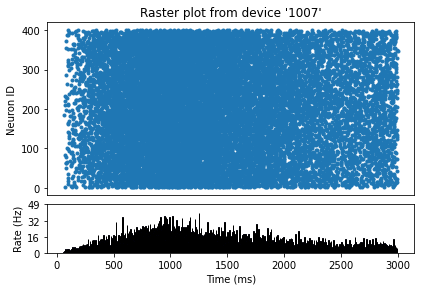

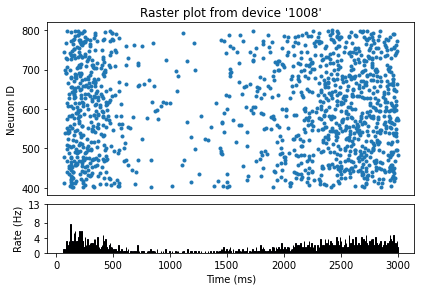

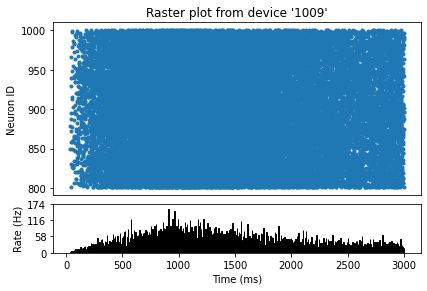

In [26]:
nest.raster_plot.from_device(spikes_a, hist=True)
nest.raster_plot.from_device(spikes_b, hist=True)
nest.raster_plot.from_device(spikes_i, hist=True)
plt.show()

In [27]:
help(nest)

Help on package nest:

NAME
    nest - Initializer of PyNEST.

PACKAGE CONTENTS
    hl_api
    import_libs
    lib (package)
    ll_api
    pynestkernel
    raster_plot
    tests (package)
    topology (package)
    visualization
    voltage_trace

SUBMODULES
    kernel

FUNCTIONS
    test()
        Runs all PyNEST unit tests.

FILE
    /home/amtra/nest-simulator-2.18.0/b/lib/python3.6/site-packages/nest/__init__.py




In [28]:
help(nest.raster_plot)

Help on module nest.raster_plot in nest:

NAME
    nest.raster_plot - Functions for raster plotting.

FUNCTIONS
    extract_events(data, time=None, sel=None)
        Extract all events within a given time interval.
        
        Both time and sel may be used at the same time such that all
        events are extracted for which both conditions are true.
        
        Parameters
        ----------
        data : list
            Matrix such that
            data[:,0] is a vector of all gids and
            data[:,1] a vector with the corresponding time stamps.
        time : list, optional
            List with at most two entries such that
            time=[t_max] extracts all events with t< t_max
            time=[t_min, t_max] extracts all events with t_min <= t < t_max
        sel : list, optional
            List of gids such that
            sel=[gid1, ... , gidn] extracts all events from these gids.
            All others are discarded.
        
        Returns
        -----

# FILE CSV PER PLOT

In [29]:
import pandas as pd 

events = nest.GetStatus(spikes_a,"events")
df = pd.DataFrame(events)
senders = pd.DataFrame(df.senders.array)
times = pd.DataFrame(df.times.array)
senders = senders.T
times = times.T
PopA = pd.concat([senders,times],axis = 1)
PopA.columns =['Senders', 'Time']
PopA.to_csv('PopA.csv', index = False, float_format = '%.2f')

In [30]:
import pandas as pd 

events_B = nest.GetStatus(spikes_b,"events")
df_B = pd.DataFrame(events_B)
senders_B = pd.DataFrame(df_B.senders.array)
times_B = pd.DataFrame(df_B.times.array)
senders_B = senders_B.T
times_B = times_B.T
PopB = pd.concat([senders_B,times_B],axis = 1)
PopB.columns =['Senders', 'Time']
PopB.to_csv('PopB.csv', index = False, float_format = '%.2f')

In [31]:
import pandas as pd 

events_i = nest.GetStatus(spikes_i,"events")
df_i = pd.DataFrame(events_i)
senders_i = pd.DataFrame(df_i.senders.array)
times_i = pd.DataFrame(df_i.times.array)
senders_i = senders_i.T
times_i = times_i.T
PopI = pd.concat([senders_i,times_i],axis = 1)
PopI.columns =['Senders', 'Time']
PopI.to_csv('PopI.csv', index = False, float_format = '%.2f')

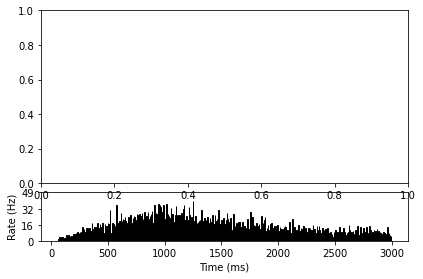

In [32]:
import pylab

hist_binwidth = 5.0
ts, gids = nest.raster_plot._from_memory(spikes_a)

color_marker = ".k"
color_bar = "gray"
color_edge = "black"

pylab.axes([0.1, 0.1, 0.85, 0.17])
t_bins = numpy.arange(numpy.amin(ts), numpy.amax(ts),float(hist_binwidth))
n, bins = nest.raster_plot._histogram(ts, bins=t_bins)
num_neurons = len(numpy.unique(gids))
heights = 1000 * n / (hist_binwidth * num_neurons)

pylab.bar(t_bins, heights, width=hist_binwidth, color=color_bar,edgecolor=color_edge)
pylab.yticks([ int(x) for x in numpy.linspace(0.0, int(max(heights) * 1.1) + 5, 4) ])
pylab.ylabel("Rate (Hz)")
pylab.xlabel(xlabel = "Time (ms)")
pylab.xlim(pylab.xlim())
pylab.axes(pylab.axes([0.1, 0.3, 0.85, 0.6]))

t_bins = pd.DataFrame(t_bins)
heights = pd.DataFrame(heights)
PopA_hist = pd.concat([t_bins,heights],axis = 1)
PopA_hist.columns =['time', 'heights']
PopA_hist

PopA_hist.to_csv('PopA_hist.csv', index = False, float_format = '%.2f')

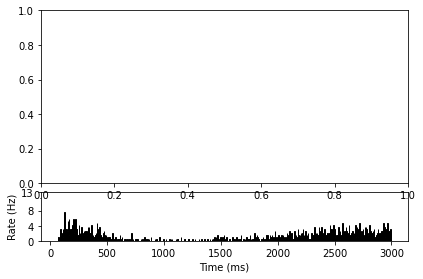

In [33]:
import pylab

hist_binwidth = 5.0
ts, gids = nest.raster_plot._from_memory(spikes_b)

color_marker = ".k"
color_bar = "gray"
color_edge = "black"

pylab.axes([0.1, 0.1, 0.85, 0.17])
t_bins = numpy.arange(numpy.amin(ts), numpy.amax(ts),float(hist_binwidth))
n, bins = nest.raster_plot._histogram(ts, bins=t_bins)
num_neurons = len(numpy.unique(gids))
heights = 1000 * n / (hist_binwidth * num_neurons)

pylab.bar(t_bins, heights, width=hist_binwidth, color=color_bar,edgecolor=color_edge)
pylab.yticks([ int(x) for x in numpy.linspace(0.0, int(max(heights) * 1.1) + 5, 4) ])
pylab.ylabel("Rate (Hz)")
pylab.xlabel(xlabel = "Time (ms)")
pylab.xlim(pylab.xlim())
pylab.axes(pylab.axes([0.1, 0.3, 0.85, 0.6]))

t_bins = pd.DataFrame(t_bins)
heights = pd.DataFrame(heights)
PopB_hist = pd.concat([t_bins,heights],axis = 1)
PopB_hist.columns =['time', 'heights']
PopB_hist

PopB_hist.to_csv('PopB_hist.csv', index = False, float_format = '%.2f')

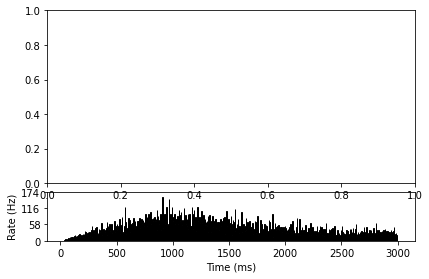

In [34]:
import pylab

hist_binwidth = 5.0
ts, gids = nest.raster_plot._from_memory(spikes_i)

color_marker = ".k"
color_bar = "gray"
color_edge = "black"

pylab.axes([0.1, 0.1, 0.85, 0.17])
t_bins = numpy.arange(numpy.amin(ts), numpy.amax(ts),float(hist_binwidth))
n, bins = nest.raster_plot._histogram(ts, bins=t_bins)
num_neurons = len(numpy.unique(gids))
heights = 1000 * n / (hist_binwidth * num_neurons)

pylab.bar(t_bins, heights, width=hist_binwidth, color=color_bar,edgecolor=color_edge)
pylab.yticks([ int(x) for x in numpy.linspace(0.0, int(max(heights) * 1.1) + 5, 4) ])
pylab.ylabel("Rate (Hz)")
pylab.xlabel(xlabel = "Time (ms)")
pylab.xlim(pylab.xlim())
pylab.axes(pylab.axes([0.1, 0.3, 0.85, 0.6]))

t_bins = pd.DataFrame(t_bins)
heights = pd.DataFrame(heights)
PopI_hist = pd.concat([t_bins,heights],axis = 1)
PopI_hist.columns =['time', 'heights']
PopI_hist

PopI_hist.to_csv('PopI_hist.csv', index = False, float_format = '%.2f')